# Deep Learning Part of Speech Tagger <br>
Using Keras and Tensorflow to create feedforward nueral network <br>
## Functions <br>
Imports:


In [5]:
import random
import nltk
from nltk.corpus import treebank
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils, plot_model
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
CUSTOM_SEED = 42

Basic features to feed in nueral network

In [6]:
def add_basic_features(sentence_terms, index):
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

Untag the sentence and return just the words

In [7]:
def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

Return list of basic feature in x and return list of all tags in y

In [8]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

Construct, compile and return the keras model <br>
sequential model allow user to construct easily that simply create each layer one by one <br>
Dropout regularization prevent overfitting, in our case its 20%

In [10]:
def build_model(input_dim, hidden_neurons, output_dim):
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Create a plot that show model performence accuracy and loss through out epochs

In [11]:
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    green = '#72C29B'
    orange = '#FFA577'
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, green, linewidth=1,
             label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, orange,
            linewidth=1, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', fontweight='bold')
    ax2.plot(range(1, len(train_acc) + 1), train_acc, green, linewidth=1,
             label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, orange,
             linewidth=1, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', fontweight='bold')
    #with plt.xkcd():
    plt.tight_layout()
    plt.show()

## Main
Use nltk preTagged data, treebank as input data. For performance purpose use only the first 100 sentences.Store all the treebank tags

In [13]:
np.random.seed(CUSTOM_SEED)
sentences = treebank.tagged_sents(tagset='universal')[:100]
tags = set([tag for sentence in treebank.tagged_sents() for _, tag in sentence])

Seperate the data into Train set 60%, validation set 20% and Test set 20%. 

In [14]:
train_test_cutoff = int(.80 * len(sentences))
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

#### Encoding <br>
extract features and tags from the setences. X as input variables, y as output variables

In [23]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

fit DictVectorizer another word construct the DicVectorizer to vectorize the data later on

In [21]:
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

covert X train set, test set and x validation into numpy matrices

In [24]:
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

fit LabelEncoder another word construct the LabelEncoder to vectorize the data later on

In [26]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

LabelEncoder()

Encode class value as integers and convert integer to dummy variables, one hot encoded

In [27]:
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

Declare parameters for the models

In [29]:
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

create sklearn classifier and fit the classifier

In [31]:
clf = KerasClassifier(**model_params)
hist = clf.fit(X_train, y_train)

Train on 1395 samples, validate on 499 samples
Epoch 1/5
1395/1395 [==============================] - 1s 761us/step - loss: 2.2158 - acc: 0.2961 - val_loss: 2.0169 - val_acc: 0.3166
Epoch 2/5
1395/1395 [==============================] - 1s 540us/step - loss: 1.9488 - acc: 0.3792 - val_loss: 1.7599 - val_acc: 0.4890
Epoch 3/5
1395/1395 [==============================] - 1s 503us/step - loss: 1.6014 - acc: 0.5498 - val_loss: 1.3816 - val_acc: 0.6954
Epoch 4/5
1395/1395 [==============================] - 1s 485us/step - loss: 1.1639 - acc: 0.7240 - val_loss: 0.9852 - val_acc: 0.7796
Epoch 5/5
1395/1395 [==============================] - 1s 538us/step - loss: 0.7644 - acc: 0.8323 - val_loss: 0.7146 - val_acc: 0.8176


plot the model performence

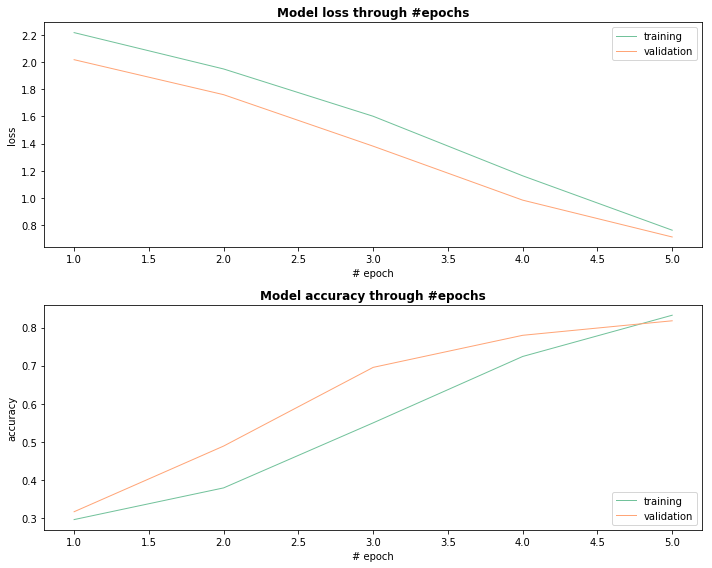

In [32]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

In [36]:
score = clf.score(X_test, y_test, verbose=0)
print('model accuracy: {}'.format(score))

model accuracy: 0.7686424478746053


## Architecture of the Multilayer perceptron and Parameters <br>
Sequential model: The sequential model allow us to simply layout the structure of the nueral network <br>
Multilayer Perceptron: Multilayer Perceptron is a class of feedforward network. The network use back-propagation algorithm to train the network <br> 
Rectified Linear Units: Activation function we are using is Rectified Linear Units (ReLU). <br>
Dropout: The dropout allow us to prevent overfitting for the model and we would use 20% <br>
Softmax Function: Softmax function convert k-dimension matrix outputs to probabilities, also known as normalized exponential function <br>
Cross Entropy: measure performence of the classification model output is probability value between 0 and 1
Adam Optimizer: used to update network weights iterate base on trainning data
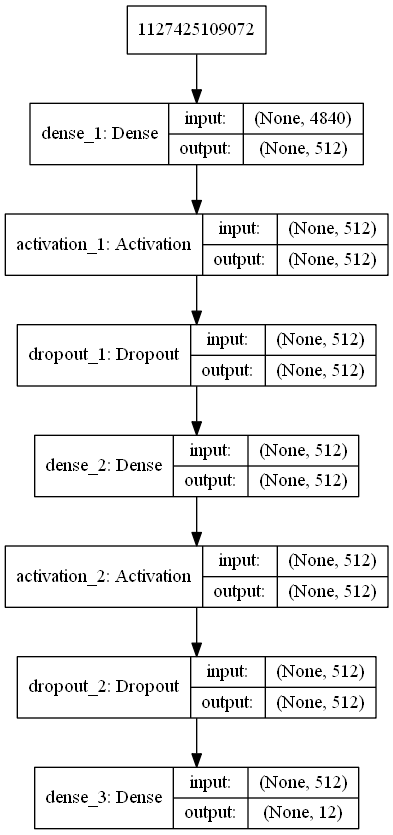<br>
#### Recitified Linear Units(ReLU)

$$f(x)=max(0,x)$$

x: input to the neuron <br>
when $x < 0$, output 0 <br>
when $x \geq 0$, output a linear function <br>
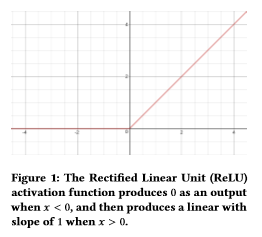

## Resources:
Deep Learning Program <br>

@online{ <br>
  author = {Bellec, Axel}, <br>
  title = {Part-of-Speech tagging tutorial with the Keras Deep Learning library - Cdiscount TechBlog}, <br>
  year = 2017, <br>
  url = {https://techblog.cdiscount.com/part-speech-tagging-tutorial-keras-deep-learning-library/} <br>
} <br>

ReLU <br>

@article{DBLP:journals/corr/abs-1803-08375, <br>
  author    = {Abien Fred Agarap}, <br>
  title     = {Deep Learning using Rectified Linear Units (ReLU)}, <br>
  journal   = {CoRR}, <br>
  volume    = {abs/1803.08375}, <br>
  year      = {2018}, <br>
  url       = {http://arxiv.org/abs/1803.08375}, <br>
  archivePrefix = {arXiv}, <br>
  eprint    = {1803.08375}, <br>
  timestamp = {Wed, 11 Apr 2018 11:12:46 +0200}, <br>
  biburl    = {https://dblp.org/rec/bib/journals/corr/abs-1803-08375}, <br>
  bibsource = {dblp computer science bibliography, https://dblp.org} <br>
} <br>

Cross-Entropy <br>

@inproceedings{Mannor:2005:CEM:1102351.1102422, <br>
 author = {Mannor, Shie and Peleg, Dori and Rubinstein, Reuven}, <br>
 title = {The Cross Entropy Method for Classification}, <br>
 booktitle = {Proceedings of the 22Nd International Conference on Machine Learning}, <br>
 series = {ICML '05}, <br>
 year = {2005}, <br>
 isbn = {1-59593-180-5}, <br>
 location = {Bonn, Germany}, <br>
 pages = {561--568}, <br>
 numpages = {8}, <br>
 url = {http://doi.acm.org/10.1145/1102351.1102422}, <br>
 doi = {10.1145/1102351.1102422}, <br>
 acmid = {1102422}, <br>
 publisher = {ACM}, <br>
 address = {New York, NY, USA}, <br>
} <br>

AdamOptimizer <br>

@article{DBLP:journals/corr/KingmaB14, <br>
  author    = {Diederik P. Kingma and <br>
               Jimmy Ba}, <br>
  title     = {Adam: {A} Method for Stochastic Optimization}, <br>
  journal   = {CoRR}, <br>
  volume    = {abs/1412.6980}, <br>
  year      = {2014}, <br>
  url       = {http://arxiv.org/abs/1412.6980}, <br>
  archivePrefix = {arXiv}, <br>
  eprint    = {1412.6980}, <br>
  timestamp = {Wed, 07 Jun 2017 14:40:52 +0200}, <br>
  biburl    = {https://dblp.org/rec/bib/journals/corr/KingmaB14}, <br>
  bibsource = {dblp computer science bibliography, https://dblp.org} <br>
} <br>

Overfitting <br>

@article{DBLP:journals/corr/abs-1207-0580, <br>
  author    = {Geoffrey E. Hinton and <br>
               Nitish Srivastava and <br>
               Alex Krizhevsky and <br>
               Ilya Sutskever and <br>
               Ruslan Salakhutdinov}, <br>
  title     = {Improving neural networks by preventing co-adaptation of feature detectors}, <br>
  journal   = {CoRR}, <br>
  volume    = {abs/1207.0580}, <br>
  year      = {2012}, <br>
  url       = {http://arxiv.org/abs/1207.0580}, <br>
  archivePrefix = {arXiv}, <br>
  eprint    = {1207.0580}, <br>
  timestamp = {Wed, 07 Jun 2017 14:40:12 +0200}, <br>
  biburl    = {https://dblp.org/rec/bib/journals/corr/abs-1207-0580}, <br>
  bibsource = {dblp computer science bibliography, https://dblp.org} <br>
} <br>

